## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (8, 7)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

import joblib

## Global Variables

In [2]:
interval = '60m' # time interval for data point
history = '2y' # time period for total history
perc_inc = 0.008 # 0.8% increase or more from interval to interval
symbol = 'IYW' # tech etf

## Yahoo Finance

In [3]:
stock_df = yf.download(tickers = symbol
                       , interval = interval
                       , period = history
                       , prepost = False
                      )

[*********************100%***********************]  1 of 1 completed


In [4]:
stock_df.head(3)

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2018-07-09 09:30:00-04:00,184.149994,184.408295,183.113602,183.240005,183.240005,0
2018-07-09 10:30:00-04:00,183.369995,183.830002,183.240005,183.660004,183.660004,10520
2018-07-09 11:30:00-04:00,183.578995,183.823700,183.550003,183.704605,183.704605,8844


In [5]:
stock_df.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-07-08 09:30:00-04:00,277.059998,278.959991,277.029999,278.269989,278.269989,40396
2020-07-08 10:30:00-04:00,278.125000,278.179993,278.125000,278.179993,278.179993,1149
2020-07-08 10:39:32-04:00,278.462097,278.462097,278.462097,278.462097,278.462097,0


## Create Percent Change

In [6]:
stock_df['Percent Change'] = (stock_df.Close - stock_df.Open) / stock_df.Open
stock_df.head(3)

,Open,High,Low,Close,Adj Close,Volume,Percent Change
Datetime,,,,,,,
2018-07-09 09:30:00-04:00,184.149994,184.408295,183.113602,183.240005,183.240005,0,-0.004942
2018-07-09 10:30:00-04:00,183.369995,183.830002,183.240005,183.660004,183.660004,10520,0.001582
2018-07-09 11:30:00-04:00,183.578995,183.823700,183.550003,183.704605,183.704605,8844,0.000684


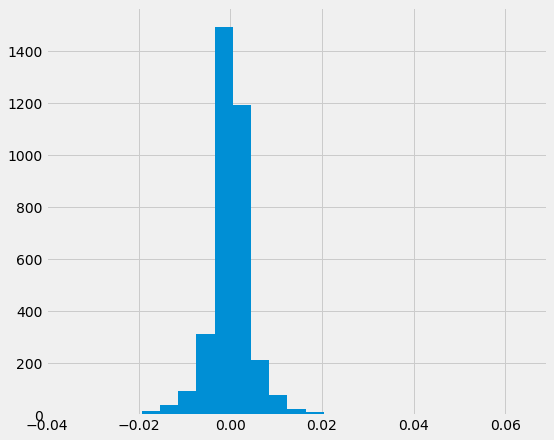

In [7]:
stock_df['Percent Change'].hist(bins=25);

In [8]:
stock_df['Percent Change'].quantile([0.84]) # 1 stdev from avg

0.84    0.003106
Name: Percent Change, dtype: float64

## Assign Direction

In [9]:
stock_df['Direction'] = np.where(stock_df['Percent Change'] > perc_inc
                                 , 1
                                 , 0
                                )

In [10]:
stock_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,Percent Change,Direction
Datetime,,,,,,,,
2020-07-07 14:30:00-04:00,277.299988,277.299988,276.369995,276.701599,276.701599,13930,-0.002158,0
2020-07-07 15:30:00-04:00,276.928986,276.980011,274.890015,275.000000,275.000000,11658,-0.006966,0
2020-07-08 09:30:00-04:00,277.059998,278.959991,277.029999,278.269989,278.269989,40396,0.004367,0
2020-07-08 10:30:00-04:00,278.125000,278.179993,278.125000,278.179993,278.179993,1149,0.000198,0
2020-07-08 10:39:32-04:00,278.462097,278.462097,278.462097,278.462097,278.462097,0,0.000000,0


## Shift Direction Column Up 1

Move decision column up by 1 cell so current hour of data will predict the next hour of data or whichever time frame interval is observed

In [11]:
direction = stock_df.Direction.values
print(f'Length Before: {len(direction)}')
direction = direction[1:len(direction)]
print(f'Length After: {len(direction)}')

Length Before: 3503
Length After: 3502


In [12]:
stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1]
stock_df_one_off['Direction'] = direction
stock_df_one_off.shape

(3502, 8)

In [13]:
stock_df_one_off.tail(5)

,Open,High,Low,Close,Adj Close,Volume,Percent Change,Direction
Datetime,,,,,,,,
2020-07-07 13:30:00-04:00,278.399994,278.480011,277.410004,277.569000,277.569000,8846,-0.002985,0
2020-07-07 14:30:00-04:00,277.299988,277.299988,276.369995,276.701599,276.701599,13930,-0.002158,0
2020-07-07 15:30:00-04:00,276.928986,276.980011,274.890015,275.000000,275.000000,11658,-0.006966,0
2020-07-08 09:30:00-04:00,277.059998,278.959991,277.029999,278.269989,278.269989,40396,0.004367,0
2020-07-08 10:30:00-04:00,278.125000,278.179993,278.125000,278.179993,278.179993,1149,0.000198,0


In [14]:
stock_df_one_off.Direction.value_counts()

0    3362
1     140
Name: Direction, dtype: int64

## Balance 1's and 0's

In [15]:
ones_count = stock_df_one_off['Direction'].value_counts()[1]
ones_count

140

In [16]:
stock_df_bal = stock_df_one_off.groupby('Direction').apply(lambda x: x.sample(n=ones_count)).reset_index(drop=True)
stock_df_bal.shape

(280, 8)

In [17]:
stock_df_bal['Direction'].value_counts() # try bootstrapping and upsampling 

1    140
0    140
Name: Direction, dtype: int64

## Check for NaN's

In [18]:
stock_df_bal.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
Percent Change    0
Direction         0
dtype: int64

In [19]:
stock_df_bal.dropna(axis=0, inplace=True)

In [20]:
stock_df_bal.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
Percent Change    0
Direction         0
dtype: int64

## Train Test Split

In [21]:
X = stock_df_bal.drop(columns=['Direction'])
y = stock_df_bal['Direction']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size=0.2
                                                    , random_state = 42
                                                   )

## Grid Search

In [23]:
grid1={'bootstrap': [True, False]
       , 'n_estimators': [5, 25, 45, 65, 85, 105, 125]
       , 'max_depth': [1, 2, 3, 4, 5, 6]
       , 'max_features': [1, 2, 3, 4, 5, 6]
       , 'min_samples_leaf': [1, 2, 3]
       , 'min_samples_split': [2, 5, 10]
      }

rf_grid_search1 = GridSearchCV(estimator = RandomForestClassifier()
                               , param_grid = grid1
                               , cv = 7
                               , n_jobs = -1
                               , verbose = 1
                              )

rf_grid_search1.fit(X_train, y_train)

Fitting 7 folds for each of 4536 candidates, totalling 31752 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 732 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 1432 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 2332 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 3432 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4732 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 6232 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 7932 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 9832 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 11932 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 14232 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 16732 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 19432 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 22332 tasks  

GridSearchCV(cv=7, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [1, 2, 3, 4, 5, 6],
                         'max_features': [1, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [5, 25, 45, 65, 85, 105, 125]},
             verbose=1)

In [24]:
rf_grid_search1.best_params_

{'bootstrap': True,
 'max_depth': 6,
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 5}

## Save Best Parameters

In [25]:
joblib.dump(rf_grid_search1.best_params_
            , 'rfc_1hr.pkl' # 1d or 1hr change ***
            , compress = 1
           )

['rfc_1hr.pkl']

## Load Best parameters

In [26]:
rfc = RandomForestClassifier(random_state = 42
                             , n_jobs = -1
                             , verbose = 1
                            ).set_params(**joblib.load('rfc_1hr.pkl')) # 1d or 1hr change ***

## Random Forest Classifier

In [27]:
# rfc loaded from above
# rfc = RandomForestClassifier(bootstrap = True
#                              , n_estimators = 5 # how many trees, optimize using grid search   
#                              , random_state = 42
#                              , verbose = 1
#                              , n_jobs = -1 # uses all your processer cores
#                              , max_depth = 6 # height of tree
#                              , max_features = 3 # random sampling of features
#                              , min_samples_leaf = 2
#                              , min_samples_split = 2
#                              # need to tune n_estimators, n max_depth, max_features
#                             )

In [28]:
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

y_probs = rfc.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


## Cross Val Score

In [29]:
cval = cross_val_score(rfc
                       , X_train
                       , y_train
                       , scoring='accuracy'
                       , cv=7
                      )

print(f'Cross-Validation Score: {np.mean(cval)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

Cross-Validation Score: 0.7053571428571429


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Par

## Receiver Operating Characteristic (ROC) Curve

In [30]:
roc_score = roc_auc_score(y_test
                          , y_probs
                         )
roc_score

0.7302295918367346

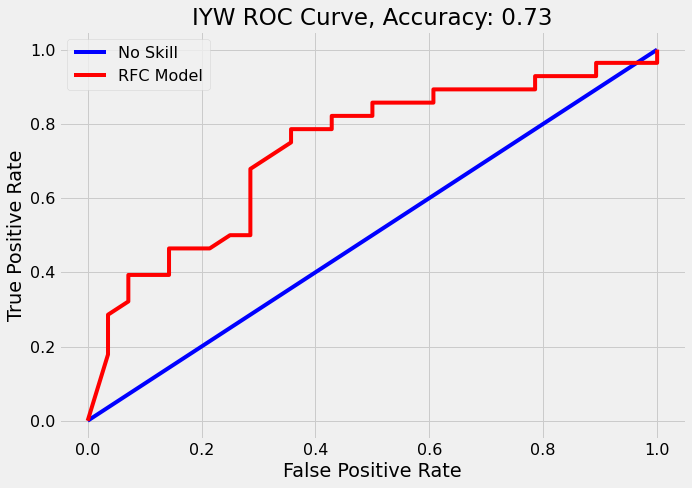

In [31]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(10,7))

# No Skill Line Data
base_fpr, base_tpr, _ = roc_curve(y_test
                                  , [1 for _ in range(len(y_test))]
                                 ) 

# Model Data
model_fpr, model_tpr, _ = roc_curve(y_test
                                    , y_probs
                                   )

plt.plot(base_fpr
         , base_tpr
         , 'b'
         , label='No Skill'
        )

plt.plot(model_fpr
         , model_tpr
         , 'r'
         , label='RFC Model'
        )

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{symbol} ROC Curve, Accuracy: {round(roc_score, 3)}')
plt.legend();

## Precision Recall Curve

In [32]:
# Precision Recall Data
rf_prec, rf_recall, _ = precision_recall_curve(y_test
                                             , y_probs
                                            )

auc_score = auc(rf_recall, rf_prec)
auc_score

0.7395762689250183

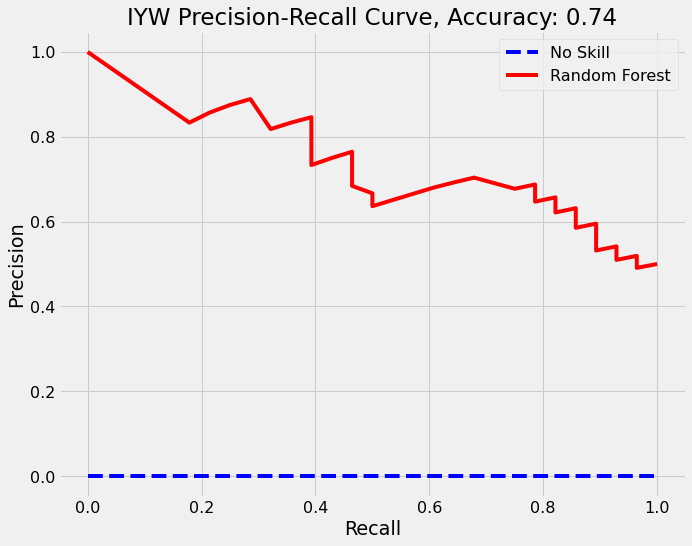

In [33]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10, 8)



# No Skill Line
plt.plot([0, 0]
         , linestyle = '--'
         , color = 'b'
         , label = 'No Skill'
        )

# PR Line
plt.plot(rf_recall
         , rf_prec
         , color = 'r'
         , label = 'Random Forest'
        )

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'{symbol} Precision-Recall Curve, Accuracy: {round(auc_score, 3)}')
plt.legend();

## Confusion Matrix

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


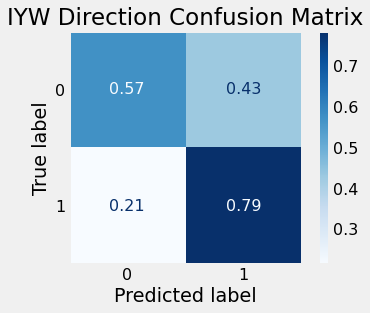

In [34]:
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['font.size'] = 16
disp = plot_confusion_matrix(rfc
                             , X_test
                             , y_test
                             , cmap = plt.cm.Blues
                             , normalize = 'true'
                            )
disp.ax_.grid(False)
disp.ax_.set_title(f'{symbol} Direction Confusion Matrix');

## Feature Importances

In [35]:
features_df = pd.DataFrame({'Feature': X_train.columns
                            , 'Importances': rfc.feature_importances_
                           }).sort_values('Importances'
                                          , ascending=False
                                         )
features_df

,Feature,Importances
5,Volume,0.379520
6,Percent Change,0.331947
4,Adj Close,0.079592
0,Open,0.068924
1,High,0.064551
3,Close,0.050165
2,Low,0.025301


## Make A Prediction

In [36]:
stock_df.tail(3)

,Open,High,Low,Close,Adj Close,Volume,Percent Change,Direction
Datetime,,,,,,,,
2020-07-08 09:30:00-04:00,277.059998,278.959991,277.029999,278.269989,278.269989,40396,0.004367,0
2020-07-08 10:30:00-04:00,278.125000,278.179993,278.125000,278.179993,278.179993,1149,0.000198,0
2020-07-08 10:39:32-04:00,278.462097,278.462097,278.462097,278.462097,278.462097,0,0.000000,0


In [37]:
last = stock_df.drop(columns=['Direction']).iloc[-1]
last

Open              278.462097
High              278.462097
Low               278.462097
Close             278.462097
Adj Close         278.462097
Volume              0.000000
Percent Change      0.000000
Name: 2020-07-08 10:39:32-04:00, dtype: float64

In [38]:
if rfc.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {symbol} on the {interval} for {round(perc_inc * 100, 1)}% increase.')
else:
    print(f'Sell or hold {symbol} on the {interval} interval for expected {round(perc_inc * 100, 1)}% increase.')

Sell or hold IYW on the 60m interval for expected 0.8% increase.


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Try Gradient Boosting: n_estimators, n_splits, n_depths, learning rate, etc...

### Make A Function